In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime
import statsmodels.tsa.api as smt
from IPython.display import display
from pandasql import *
from dateutil import parser
import colorsys as ps

In [47]:
def loadData(fileName):
    dir=os.path.dirname(os.path.abspath("__file__"))
    # dir = os.path.dirname(__file__)
    # print("abs---",dir)
    filename = dir+'\\data\\' + fileName;
    # print("filename--",filename)
    return pd.read_csv(filename, low_memory=False,encoding='latin-1')  

# Loading flight Data

In [48]:
# flight_data=loadData("selectedFlightData.csv")
flight_data=loadData("Flight_Forecast_data.csv")
print(len(flight_data))
flight_data.head()



362330


,Flight_No,org,dst,SCH_DEP_DATE,BKD_WT_sum,BKD_VOL_sum,CHG_WT_BU_sum,count,OPN_SUFX,INHOUSE_AC_TYP,...,AC_CGO_WT_BU,AC_CGO_VOL_BU,CMRCL_CGO_WT_BU,CMRCL_CGO_VOL_BU,NOOP_CAN_IND,ISO_CODE,EST_CGO_PLOD_WT_BU,EST_CGO_PLOD_VOL_BU,EST_WT_BU,EST_VOL_BU
0,2999,DCW,NCL,2019-06-02T00:00:00.000Z,17269.500,70.514913,17601.000,32,NaN,388R,...,15000.0,60.0,20280.07,70.195783,NaN,AE,20280.07,70.195783,410.00,0.542169
1,2999,DCW,NCL,2020-05-21T00:00:00.000Z,22639.030,126.371295,25426.330,40,NaN,77WER,...,30000.0,100.0,46919.56,124.398563,NaN,AE,46919.56,124.398563,24703.36,31.996168
2,2999,DCW,NCL,2020-07-12T00:00:00.000Z,21443.040,95.318517,22224.430,18,NaN,77WEQ,...,20000.0,100.0,32731.71,120.598802,NaN,AE,32731.71,120.598802,7728.00,6.035928
3,2999,DCW,NCL,2020-10-21T00:00:00.000Z,12198.506,78.929117,14969.203,19,NaN,388T,...,8000.0,30.0,62547.06,98.043114,NaN,AE,62547.06,98.043114,50262.40,84.445509
4,3999,NCL,DCW,2019-02-05T00:00:00.000Z,9460.200,45.176032,10310.500,30,NaN,388L,...,15000.0,60.0,15000.00,60.000000,NaN,GB,39901.71,96.943533,21480.16,28.982994


In [49]:
flight_data['SCH_DEP_DATE'] = pd.to_datetime(flight_data['SCH_DEP_DATE']).dt.date

# Loading Holiday Data

In [50]:
holiday_data=loadData("Holidays Final.csv")
holiday_data.head()


,Region,Month,From_date,to_date,Holiday,Country
0,Africa,Jan-19,01/01/2019,01/01/2019,Independence Day,REPUBLIC OF THE SUDAN
1,Africa,Jan-19,06/01/2019,06/01/2019,Epiphany,ETHIOPIA
2,Africa,Jan-19,11/01/2019,11/01/2019,Proclamation of Independence,MOROCCO
3,Africa,Jan-19,12/01/2019,12/01/2019,Revolution Day,TANZANIA
4,Africa,Jan-19,14/01/2019,14/01/2019,Revolution Day,TUNISIA


# Loading Airport Data

In [51]:
airport_data=loadData("airport_code.csv")
airport_data.head()


,CITY,AIRPORT_CODE,ISO_CODE,COUNTRY_NAME,COUNTRY_CODE,REPORTING_CURRENCY,TERRITORY_NAME,TERRITORY_CODE,REGION_NAME,REGION_CODE,...,AREA_CODE,FINANCIAL_YEAR,FY_START_DATE,FY_END_DATE,VERSION,LAST_MODIFIED_DATE,LAST_MODIFIED_USER,CITY_CODE,CITY_NAME,AIRPORT_NAME
0,MARIBOR,MBX,SI,SLOVENIA,177.0,EUR,SLOVENIA,0,EUROPE,51.0,...,COW,FY20,01/04/2020,31/03/2021,1,27/03/2020,scv_ops,MBX,Maribor,Edvard Rusjan
1,Dummy Target City,249,FM,MICRONESIA,232.0,USD,MICRONESIA,0,ANZ,67.0,...,COE,FY20,01/04/2020,31/03/2021,1,27/03/2020,scv_ops,NaN,NaN,Dummy Target City
2,ZILINA,ILZ,SK,SLOVAKIA,192.0,EUR,SLOVAKIA,0,EUROPE,51.0,...,COW,FY20,01/04/2020,31/03/2021,1,27/03/2020,scv_ops,ILZ,Zilina,NaN
3,SLIAC,SLD,SK,SLOVAKIA,192.0,EUR,SLOVAKIA,0,EUROPE,51.0,...,COW,FY20,01/04/2020,31/03/2021,1,27/03/2020,scv_ops,SLD,Sliac,NaN
4,KENEMA,KEN,SL,SIERRA LEONE,119.0,USD,SIERRA LEONE,0,AFRICA,70.0,...,COA,FY20,01/04/2020,31/03/2021,1,27/03/2020,scv_ops,KEN,Kenema,NaN


In [52]:
def trimAndUpperCaseFlt(orgn_dst_flight_contry_df):
    orgn_dst_flight_contry_df['ORG_CNTRY_NAME'] = orgn_dst_flight_contry_df['ORG_CNTRY_NAME'].str.upper()
    orgn_dst_flight_contry_df['DST_CNTRY_NAME'] = orgn_dst_flight_contry_df['DST_CNTRY_NAME'].str.upper()
    orgn_dst_flight_contry_df['ORG_CNTRY_NAME'] = orgn_dst_flight_contry_df['ORG_CNTRY_NAME'].str.strip()
    orgn_dst_flight_contry_df['DST_CNTRY_NAME'] = orgn_dst_flight_contry_df['DST_CNTRY_NAME'].str.strip()

# Get selected holiday columns and explod the comma saperated country 

In [53]:
def getSelectedHolidayCol(selected_holiday_col_df):
    selected_holiday_col_df=selected_holiday_col_df[['Country',	'From_date','to_date']]
    selected_holiday_col_df['Country'] = selected_holiday_col_df['Country'].str.upper()
    selected_holiday_col_df['Country'] = selected_holiday_col_df['Country'].str.strip()
    selected_holiday_col_df['From_date'] = pd.to_datetime(selected_holiday_col_df['From_date']).dt.date
    selected_holiday_col_df['to_date'] = pd.to_datetime(selected_holiday_col_df['to_date']).dt.date

    selected_holiday_col_df=selected_holiday_col_df.assign  (countrylist=selected_holiday_col_df.Country.str.split(',')).explode('countrylist').reset_index(drop=True)
    return selected_holiday_col_df

# Get selected Aiport data coulmns

In [54]:
def getSelectedAirportCol(selected_airport_col_df):
    selected_airport_col_df=selected_airport_col_df[['AIRPORT_CODE','AIRPORT_NAME','COUNTRY_NAME',	'REGION_NAME']]
    return selected_airport_col_df

# Select Flight data columns 

In [55]:
flight_data.head()

,Flight_No,org,dst,SCH_DEP_DATE,BKD_WT_sum,BKD_VOL_sum,CHG_WT_BU_sum,count,OPN_SUFX,INHOUSE_AC_TYP,...,AC_CGO_WT_BU,AC_CGO_VOL_BU,CMRCL_CGO_WT_BU,CMRCL_CGO_VOL_BU,NOOP_CAN_IND,ISO_CODE,EST_CGO_PLOD_WT_BU,EST_CGO_PLOD_VOL_BU,EST_WT_BU,EST_VOL_BU
0,2999,DCW,NCL,2019-06-02,17269.500,70.514913,17601.000,32,NaN,388R,...,15000.0,60.0,20280.07,70.195783,NaN,AE,20280.07,70.195783,410.00,0.542169
1,2999,DCW,NCL,2020-05-21,22639.030,126.371295,25426.330,40,NaN,77WER,...,30000.0,100.0,46919.56,124.398563,NaN,AE,46919.56,124.398563,24703.36,31.996168
2,2999,DCW,NCL,2020-07-12,21443.040,95.318517,22224.430,18,NaN,77WEQ,...,20000.0,100.0,32731.71,120.598802,NaN,AE,32731.71,120.598802,7728.00,6.035928
3,2999,DCW,NCL,2020-10-21,12198.506,78.929117,14969.203,19,NaN,388T,...,8000.0,30.0,62547.06,98.043114,NaN,AE,62547.06,98.043114,50262.40,84.445509
4,3999,NCL,DCW,2019-02-05,9460.200,45.176032,10310.500,30,NaN,388L,...,15000.0,60.0,15000.00,60.000000,NaN,GB,39901.71,96.943533,21480.16,28.982994


In [56]:
def getSelectedFlightCol(dataframe):
    selected_flights_colms_df=dataframe[['Flight_No','org','dst','SCH_DEP_DATE','BKD_WT_sum','BKD_VOL_sum','CHG_WT_BU_sum',
        'INHOUSE_AC_TYP','OPN_MODE','SVC_TYP','AC_CGO_WT_BU',	'AC_CGO_VOL_BU',
        'CMRCL_CGO_WT_BU','CMRCL_CGO_VOL_BU','NOOP_CAN_IND',	'ISO_CODE',	'EST_CGO_PLOD_WT_BU',
        'EST_CGO_PLOD_VOL_BU'
    ]]
    
    selected_flights_colms_df[selected_flights_colms_df["BKD_WT_sum"] < 0] = 0
    selected_flights_colms_df[selected_flights_colms_df["EST_CGO_PLOD_WT_BU"] < 0] = 0
    selected_flights_colms_df[selected_flights_colms_df["CHG_WT_BU_sum"] < 0] = 0
    
    return selected_flights_colms_df

# filtering columns

In [57]:
selected_flight_col_df=getSelectedFlightCol(flight_data)
# selected_flight_col_df=trimAndUpperCaseFlt(selected_flight_col_df)
selected_holiday_col_df=getSelectedHolidayCol(holiday_data)
selected_aiport_col_df=getSelectedAirportCol(airport_data)

# Join Origin of flight and country to get the origin country and region information

In [58]:

def joinOrgFlightAndContry(selected_flight_col_df,selected_aiport_col_df):
    
    flight_aiport_df=pd.merge(selected_flight_col_df,selected_aiport_col_df,how='left',left_on=['org'],right_on=        ['AIRPORT_CODE'])
    flight_aiport_df = flight_aiport_df.rename(columns={'COUNTRY_NAME': 'ORG_CNTRY_NAME',
                                'REGION_NAME':'ORG_REGION_NAME',
                                'AIRPORT_CODE':'ORG_AIRPORT_CODE',
                                'AIRPORT_NAME':'ORG_AIRPORT_NAME'})
    # display(flight_aiport_df)
    flight_aiport_df['ORG_CNTRY_NAME'] = flight_aiport_df['ORG_CNTRY_NAME'].str.upper()
    flight_aiport_df['ORG_CNTRY_NAME'] = flight_aiport_df['ORG_CNTRY_NAME'].str.strip()
    return flight_aiport_df
orgn_flight_contry_df=joinOrgFlightAndContry(selected_flight_col_df,selected_aiport_col_df)


# Join destination and country master to get destination country and region information

In [59]:
def joinDstFlightAndContry(selected_flight_col_df,selected_aiport_col_df):
    flight_aiport_df=pd.merge(selected_flight_col_df,selected_aiport_col_df,how='left',left_on=['dst'],right_on=['AIRPORT_CODE'])
    flight_aiport_df = flight_aiport_df.rename(columns={'COUNTRY_NAME': 'DST_CNTRY_NAME',
                                'REGION_NAME':'DST_REGION_NAME',
                                'AIRPORT_CODE':'DST_AIRPORT_CODE',
                                'AIRPORT_NAME':'DST_AIRPORT_NAME'})
    flight_aiport_df['DST_CNTRY_NAME'] = flight_aiport_df['DST_CNTRY_NAME'].str.upper()
    flight_aiport_df['DST_CNTRY_NAME'] = flight_aiport_df['DST_CNTRY_NAME'].str.strip()                        
    return flight_aiport_df;
orgn_dst_flight_contry_df=joinDstFlightAndContry(orgn_flight_contry_df,selected_aiport_col_df)

# Count and Replace NA

In [60]:
def replaceNAN(flt_airpot_holiday_df):
    nan_count=flt_airpot_holiday_df.isna().sum().sum()
    print("NAN count--",nan_count)
    flt_airpot_holiday_df = flt_airpot_holiday_df.replace(np.nan, 0)
    nan_count=flt_airpot_holiday_df.isna().sum().sum()
    print("NAN count--",nan_count)
    return flt_airpot_holiday_df;

# Joining flight Origin with holiday data to check weather OD departure date is fall in any holiday

In [61]:

def joinFlighOrgAndHolidayData(orgn_dst_flight_contry_df,selected_holiday_col_df):
    flt_hlyday_flg_query = '''
        select flt.Flight_No,flt.org, flt.dst, flt.SCH_DEP_DATE, 1 as org_hday_flg
        from orgn_dst_flight_contry_df flt
        left join selected_holiday_col_df hldy 
        on (flt.ORG_CNTRY_NAME=hldy.Country or coalesce(hldy.Country,true))
        where flt.SCH_DEP_DATE >= hldy.From_date and flt.SCH_DEP_DATE <= hldy.to_date
        
    '''
    joined_flt_hlday_flag_df = ps.sqldf(flt_hlyday_flg_query,locals())

    final_flt_hlyday_query = '''
        select flt.*,coalesce(hldy.org_hday_flg,0) as org_hday_flg
        from orgn_dst_flight_contry_df flt
        left join joined_flt_hlday_flag_df hldy 
        on (flt.org=hldy.org 
            and flt.dst=hldy.dst 
            and flt.Flight_No=hldy.Flight_No 
            and flt.SCH_DEP_DATE=hldy.SCH_DEP_DATE
            )
    '''
    org_dst_flight_holidate_df = ps.sqldf(final_flt_hlyday_query,locals())

    return org_dst_flight_holidate_df

orgn_dst_flt_cntry_orgn_hlyday_df=joinFlighOrgAndHolidayData(orgn_dst_flight_contry_df,selected_holiday_col_df)
orgn_dst_flt_cntry_orgn_hlyday_df.head()
# display(orgn_dst_flt_cntry_orgn_hlyday_df)
# print("orgn holiday--",len(orgn_dst_flt_cntry_orgn_hlyday_df.index))
orgn_dst_flt_cntry_orgn_hlyday_df=orgn_dst_flt_cntry_orgn_hlyday_df.drop_duplicates()


# Joining flight Destination with holiday data to check weather OD departure date is fall in any holiday

In [62]:
def joinFlighDstAndHolidayData(orgn_dst_flight_contry_df,selected_holiday_col_df):
    # display(orgn_dst_flight_contry_df)
    # display(selected_holiday_col_df)
    
    flt_hlyday_flg_query = '''
        select flt.Flight_No,flt.org, flt.dst, flt.SCH_DEP_DATE, 1 as dst_hday_flg
        from orgn_dst_flight_contry_df flt
        left join selected_holiday_col_df hldy 
        on (flt.DST_CNTRY_NAME=hldy.Country or coalesce(hldy.Country,true) )
        where flt.SCH_DEP_DATE >= hldy.From_date and flt.SCH_DEP_DATE <= hldy.to_date
    '''
    joined_flt_hlday_flag_df = ps.sqldf(flt_hlyday_flg_query,locals())

    final_flt_hlyday_query = '''
        select flt.*, coalesce(hldy.dst_hday_flg,0) as dst_hday_flg
        from orgn_dst_flight_contry_df flt
        left join joined_flt_hlday_flag_df hldy 
        on (flt.org=hldy.org 
            and flt.dst=hldy.dst 
            and flt.Flight_No=hldy.Flight_No 
            and flt.SCH_DEP_DATE=hldy.SCH_DEP_DATE
            )
    '''
    org_dst_flight_holidate_df = ps.sqldf(final_flt_hlyday_query,locals())
    return org_dst_flight_holidate_df

orgn_dst_flt_cntry_dstnorgn_hlyday_df=joinFlighDstAndHolidayData(orgn_dst_flt_cntry_orgn_hlyday_df,selected_holiday_col_df)
orgn_dst_flt_cntry_dstnorgn_hlyday_df.head()

,Flight_No,org,dst,SCH_DEP_DATE,BKD_WT_sum,BKD_VOL_sum,CHG_WT_BU_sum,INHOUSE_AC_TYP,OPN_MODE,SVC_TYP,...,ORG_AIRPORT_CODE,ORG_AIRPORT_NAME,ORG_CNTRY_NAME,ORG_REGION_NAME,DST_AIRPORT_CODE,DST_AIRPORT_NAME,DST_CNTRY_NAME,DST_REGION_NAME,org_hday_flg,dst_hday_flg
0,2999,DCW,NCL,2019-06-02,17269.500,70.514913,17601.000,388R,J,J,...,None,None,None,None,NCL,International,UNITED KINGDOM,EUROPE,0,1
1,2999,DCW,NCL,2020-05-21,22639.030,126.371295,25426.330,77WER,J,J,...,None,None,None,None,NCL,International,UNITED KINGDOM,EUROPE,0,0
2,2999,DCW,NCL,2020-07-12,21443.040,95.318517,22224.430,77WEQ,J,J,...,None,None,None,None,NCL,International,UNITED KINGDOM,EUROPE,0,0
3,2999,DCW,NCL,2020-10-21,12198.506,78.929117,14969.203,388T,J,J,...,None,None,None,None,NCL,International,UNITED KINGDOM,EUROPE,0,0
4,3999,NCL,DCW,2019-02-05,9460.200,45.176032,10310.500,388L,J,J,...,NCL,International,UNITED KINGDOM,EUROPE,None,None,None,None,0,0


# Droping columns

In [63]:
def dropColumns(flt_airpot_holiday_df):
    colm_array=['ORG_CNTRY_HOLIDAY','ORG_HOLIDAY_FROM_DATE','ORG_HOLIDAY_TO_DATE','DST_CNTRY_HOLIDAY',	    'DST_HOLIDAY_FROM_DATE','DST_HOLIDAY_TO_DATE','ORG_REGION_NAME','DST_REGION_NAME','ORG_AIRPORT_CODE',	'ORG_AIRPORT_NAME','ORG_CNTRY_NAME','DST_AIRPORT_CODE','DST_AIRPORT_NAME','DST_CNTRY_NAME']
    flt_airpot_holiday_df_droped=flt_airpot_holiday_df.drop(colm_array, axis = 1)
    return flt_airpot_holiday_df_droped;

# Cleaning Holiday Data

In [64]:
# flt_airpot_holiday_drop_df=dropColumns(flt_airpot_holiday_df)
flt_airpot_holiday_drop_df=replaceNAN(orgn_dst_flt_cntry_dstnorgn_hlyday_df)
flt_airpot_holiday_drop_dup=flt_airpot_holiday_drop_df.drop_duplicates()
flt_airpot_holiday_df=flt_airpot_holiday_drop_dup
# display(flt_airpot_holiday_drop_dup)
flt_airpot_holiday_drop_dup.head()



NAN count-- 2044510
NAN count-- 0


,Flight_No,org,dst,SCH_DEP_DATE,BKD_WT_sum,BKD_VOL_sum,CHG_WT_BU_sum,INHOUSE_AC_TYP,OPN_MODE,SVC_TYP,...,ORG_AIRPORT_CODE,ORG_AIRPORT_NAME,ORG_CNTRY_NAME,ORG_REGION_NAME,DST_AIRPORT_CODE,DST_AIRPORT_NAME,DST_CNTRY_NAME,DST_REGION_NAME,org_hday_flg,dst_hday_flg
0,2999,DCW,NCL,2019-06-02,17269.500,70.514913,17601.000,388R,J,J,...,0,0,0,0,NCL,International,UNITED KINGDOM,EUROPE,0,1
1,2999,DCW,NCL,2020-05-21,22639.030,126.371295,25426.330,77WER,J,J,...,0,0,0,0,NCL,International,UNITED KINGDOM,EUROPE,0,0
2,2999,DCW,NCL,2020-07-12,21443.040,95.318517,22224.430,77WEQ,J,J,...,0,0,0,0,NCL,International,UNITED KINGDOM,EUROPE,0,0
3,2999,DCW,NCL,2020-10-21,12198.506,78.929117,14969.203,388T,J,J,...,0,0,0,0,NCL,International,UNITED KINGDOM,EUROPE,0,0
4,3999,NCL,DCW,2019-02-05,9460.200,45.176032,10310.500,388L,J,J,...,NCL,International,UNITED KINGDOM,EUROPE,0,0,0,0,0,0


# Calculate Estimated Chargable weight Ratio and chargable weight
# CHRGBL_WT_RATIO= CHG_WT_BU_sum / BKD_WT_sum
# EST_CHG_WT= EST_CGO_PLOD_WT_BU * CHRGBL_WT_RATIO


In [78]:
# Calculate Chargeable and Booked weight Ratio
def calEstimatedChgWeight(orgn_dst_flight_contry_df):
    orgn_dst_flight_contry_df.loc[(orgn_dst_flight_contry_df['CHG_WT_BU_sum'] <0)] = 1 
    orgn_dst_flight_contry_df.loc[(orgn_dst_flight_contry_df['BKD_WT_sum'] <0)] = 1 

    grp_org_dst_wt_query = '''
        select flt.org,flt.dst,sum(flt.CHG_WT_BU_sum)/sum(flt.BKD_WT_sum) as CHG_WT_RT
        from orgn_dst_flight_contry_df flt
        group by flt.org, flt.dst
    '''
    grpd_orgdst_chrgbl_rt_df = ps.sqldf(grp_org_dst_wt_query,locals())
    display(grpd_orgdst_chrgbl_rt_df)
    flt_airpot_holiday_df = grpd_orgdst_chrgbl_rt_df.replace(np.nan, 0)
    # grpd_orgdst_chrgbl_rt_df[CHG_WT_RT < 0] = 0
    # display(grpd_orgdst_chrgbl_rt_df)
    grpd_orgdst_chrgbl_rt_df.head()
    grpd_orgdst_chrgbl_rt_df.loc[(grpd_orgdst_chrgbl_rt_df['CHG_WT_RT'] <0)] = 1 
    chrbl_cal_query = '''
        select flt.*,(flt.EST_CGO_PLOD_WT_BU * rt.CHG_WT_RT) as EST_CHG_WT
        from orgn_dst_flight_contry_df flt
        left join grpd_orgdst_chrgbl_rt_df rt 
        on (flt.org=rt.org 
            and flt.dst=rt.dst 
            )
        where flt.dst=rt.dst 
    '''
    grpd_orgdst_chrgbl_rt_df = ps.sqldf(chrbl_cal_query,locals())

    # display(grpd_orgdst_chrgbl_rt_df)
    return grpd_orgdst_chrgbl_rt_df

grpd_orgdst_chrgbl_rt_df=calEstimatedChgWeight(flt_airpot_holiday_drop_dup);
print("final df")
# display(grpd_orgdst_chrgbl_rt_df)
grpd_orgdst_chrgbl_rt_df.head()

# slct_df = grpd_orgdst_chrgbl_rt_df[(grpd_orgdst_chrgbl_rt_df.org == 'DWC') &(grpd_orgdst_chrgbl_rt_df.dst == 'ICN')]



,org,dst,CHG_WT_RT
0,0,0,NaN
1,ABJ,ACC,1.106036
2,ABJ,DCW,1.012315
3,ABV,DCW,1.026904
4,ACC,ABJ,1.015055
...,...,...,...
787,ZRH,DCW,1.185706
788,ZRH,DWC,1.158214
789,ZRH,EDG,1.132012
790,ZRH,IAD,1.000000


final df


,Flight_No,org,dst,SCH_DEP_DATE,BKD_WT_sum,BKD_VOL_sum,CHG_WT_BU_sum,INHOUSE_AC_TYP,OPN_MODE,SVC_TYP,...,ORG_AIRPORT_NAME,ORG_CNTRY_NAME,ORG_REGION_NAME,DST_AIRPORT_CODE,DST_AIRPORT_NAME,DST_CNTRY_NAME,DST_REGION_NAME,org_hday_flg,dst_hday_flg,EST_CHG_WT
0,2999,DCW,NCL,2019-06-02,17269.500,70.514913,17601.000,388R,J,J,...,0,0,0,NCL,International,UNITED KINGDOM,EUROPE,0,1,21642.097658
1,2999,DCW,NCL,2020-05-21,22639.030,126.371295,25426.330,77WER,J,J,...,0,0,0,NCL,International,UNITED KINGDOM,EUROPE,0,0,50070.719657
2,2999,DCW,NCL,2020-07-12,21443.040,95.318517,22224.430,77WEQ,J,J,...,0,0,0,NCL,International,UNITED KINGDOM,EUROPE,0,0,34930.000949
3,2999,DCW,NCL,2020-10-21,12198.506,78.929117,14969.203,388T,J,J,...,0,0,0,NCL,International,UNITED KINGDOM,EUROPE,0,0,66747.776549
4,3999,NCL,DCW,2019-02-05,9460.200,45.176032,10310.500,388L,J,J,...,International,UNITED KINGDOM,EUROPE,0,0,0,0,0,0,43592.742441


# Clean Final flight Data

In [66]:
grpd_orgdst_chrgbl_rt_df=grpd_orgdst_chrgbl_rt_df.dropna()
grpd_orgdst_chrgbl_rt_df.head()
grpd_orgdst_chrgbl_rt_df=grpd_orgdst_chrgbl_rt_df.drop_duplicates()
grpd_orgdst_chrgbl_rt_df.head()

,Flight_No,org,dst,SCH_DEP_DATE,BKD_WT_sum,BKD_VOL_sum,CHG_WT_BU_sum,INHOUSE_AC_TYP,OPN_MODE,SVC_TYP,...,ORG_AIRPORT_NAME,ORG_CNTRY_NAME,ORG_REGION_NAME,DST_AIRPORT_CODE,DST_AIRPORT_NAME,DST_CNTRY_NAME,DST_REGION_NAME,org_hday_flg,dst_hday_flg,EST_CHG_WT
0,2999,DCW,NCL,2019-06-02,17269.500,70.514913,17601.000,388R,J,J,...,0,0,0,NCL,International,UNITED KINGDOM,EUROPE,0,1,21642.097658
1,2999,DCW,NCL,2020-05-21,22639.030,126.371295,25426.330,77WER,J,J,...,0,0,0,NCL,International,UNITED KINGDOM,EUROPE,0,0,50070.719657
2,2999,DCW,NCL,2020-07-12,21443.040,95.318517,22224.430,77WEQ,J,J,...,0,0,0,NCL,International,UNITED KINGDOM,EUROPE,0,0,34930.000949
3,2999,DCW,NCL,2020-10-21,12198.506,78.929117,14969.203,388T,J,J,...,0,0,0,NCL,International,UNITED KINGDOM,EUROPE,0,0,66747.776549
4,3999,NCL,DCW,2019-02-05,9460.200,45.176032,10310.500,388L,J,J,...,International,UNITED KINGDOM,EUROPE,0,0,0,0,0,0,43592.742441


# Saving cleaned data for modeling

In [67]:
def writeToCsv(df,file_name):
    dir=os.path.dirname(os.path.abspath("__file__"))
    df.to_csv(dir+'\\data\\'+file_name)
    
writeToCsv(grpd_orgdst_chrgbl_rt_df,"final_data.csv")

In [68]:
# mask = grpd_orgdst_chrgbl_rt_df['org']=='DWC' and grpd_orgdst_chrgbl_rt_df['dst']=="ICN"
# slct_df=grpd_orgdst_chrgbl_rt_df.where(mask)


In [69]:
featurs=['SCH_DEP_DATE']

# Prepare daily data for time series

In [70]:
def getDailyCargoData(data):
    daily_data = data.copy()
    daily_data = daily_data.groupby("SCH_DEP_DATE")['CHG_WT_BU_sum'].sum().reset_index()
    flight_data.SCH_DEP_DATE = pd.to_datetime(flight_data.SCH_DEP_DATE, format='%Y-%m-%d')
    return daily_data

daily_data=getDailyCargoData(grpd_orgdst_chrgbl_rt_df)
daily_data=daily_data.sort_values(by='SCH_DEP_DATE')
daily_data.head()


,SCH_DEP_DATE,CHG_WT_BU_sum
0,2018-12-31,4889827.87
1,2019-01-01,4724047.93
2,2019-01-02,4412602.48
3,2019-01-03,5126771.73
4,2019-01-04,5398925.49


In [71]:
daily_data.SCH_DEP_DATE = pd.to_datetime(daily_data.SCH_DEP_DATE, format='%Y-%m-%d')
selected_yr_df=daily_data.dropna()
# selected_yr_df=daily_data
selected_yr_df.head()


,SCH_DEP_DATE,CHG_WT_BU_sum
0,2018-12-31,4889827.87
1,2019-01-01,4724047.93
2,2019-01-02,4412602.48
3,2019-01-03,5126771.73
4,2019-01-04,5398925.49


# Determining Stationarity

     SCH_DEP_DATE  CHG_WT_BU_sum
0      2018-12-31     4889827.87
1      2019-01-01     4724047.93
2      2019-01-02     4412602.48
3      2019-01-03     5126771.73
4      2019-01-04     5398925.49
...           ...            ...
1031   2021-10-27       11801.50
1032   2021-10-28        6207.00
1033   2021-10-29        6156.50
1034   2021-10-30        6843.50
1035   2021-10-31       10000.00

[1036 rows x 2 columns]


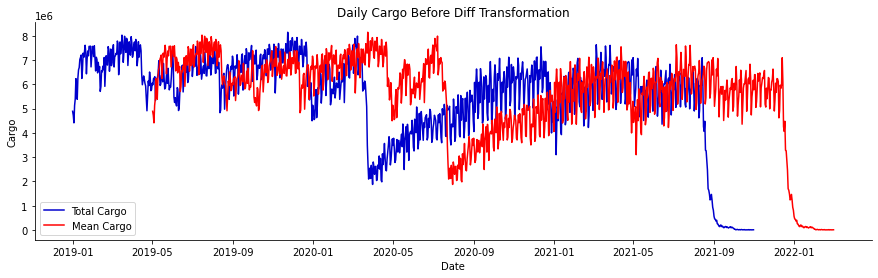

In [72]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,4))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Cargo')
#     print(data)
    second = data.groupby("SCH_DEP_DATE")[y_col].mean().reset_index()
    print(second)
    second.SCH_DEP_DATE = pd.to_datetime(second.SCH_DEP_DATE, format='%Y-%m-%d')
    sns.lineplot((second.SCH_DEP_DATE + datetime.timedelta(4*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Cargo')   
    
    ax.set(xlabel = "Date",
           ylabel = "Cargo",
           title = title)
    
    sns.despine()
    
time_plot(selected_yr_df, 'SCH_DEP_DATE', 'CHG_WT_BU_sum', 'Daily Cargo Before Diff Transformation')

     SCH_DEP_DATE  CHG_WT_BU_sum
0      2019-01-01     4724047.93
1      2019-01-02     4412602.48
2      2019-01-03     5126771.73
3      2019-01-04     5398925.49
4      2019-01-05     6233301.19
...           ...            ...
1030   2021-10-27       11801.50
1031   2021-10-28        6207.00
1032   2021-10-29        6156.50
1033   2021-10-30        6843.50
1034   2021-10-31       10000.00

[1035 rows x 2 columns]


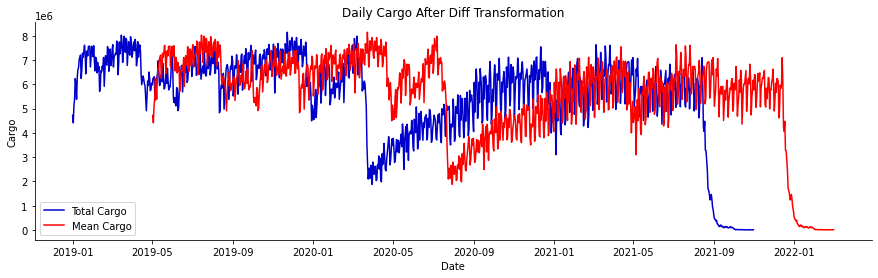

In [73]:
def get_diff(data):
    data=data.sort_values(by='SCH_DEP_DATE')
    data['cargo_diff'] = data.CHG_WT_BU_sum.diff()
    data = data.dropna()
    dir=os.path.dirname(os.path.abspath("__file__"))
    data.to_csv('../data/stationary_cargo_df.csv')
    return data
    
stationary_df = get_diff(selected_yr_df)
time_plot(stationary_df, 'SCH_DEP_DATE', 'CHG_WT_BU_sum', 'Daily Cargo After Diff Transformation')

In [74]:
# dopColm=['CHG_WT_BU_sum']
leg=18

# Observing Lags

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1035 entries, 2019-01-01 to 2021-10-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cargo_diff  1035 non-null   float64
dtypes: float64(1)
memory usage: 16.2 KB


,SCH_DEP_DATE,CHG_WT_BU_sum,cargo_diff
1,2019-01-01,4724047.93,-165779.94
2,2019-01-02,4412602.48,-311445.45
3,2019-01-03,5126771.73,714169.25
4,2019-01-04,5398925.49,272153.76
5,2019-01-05,6233301.19,834375.70


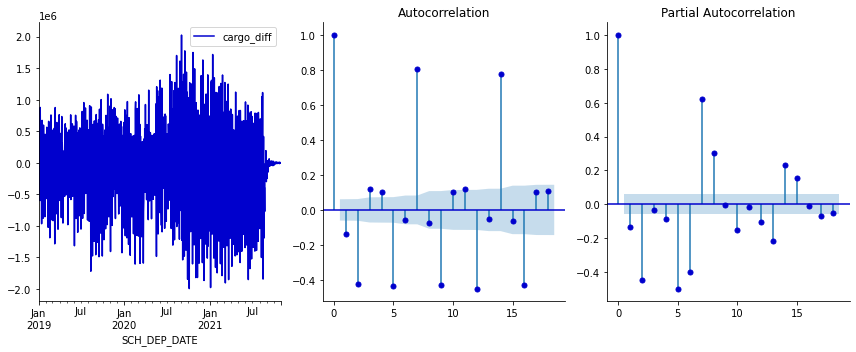

In [75]:


def plots(data, lags=None):
    
    # Convert dataframe to datetimdopColm
    dt_data = data.set_index('SCH_DEP_DATE').drop("CHG_WT_BU_sum", axis=1)
    dt_data.info()
    dt_data.dropna(axis=0)
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    dt_data.plot(ax=raw, figsize=(12, 5), color='mediumblue')
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    sns.despine()
    plt.tight_layout()

plots(stationary_df, lags=leg);
stationary_df.head()

# Preparing Dataset Modeling

In [76]:
#create dataframe for transformation from time series to supervised
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,leg):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['cargo_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    dir=os.path.dirname(os.path.abspath("__file__"))
    supervised_df.to_csv(dir+'/data/model_df.csv', index=False)
    
    return supervised_df
# display(stationary_df)
model_df = generate_supervised(stationary_df)

model_df.head()


,SCH_DEP_DATE,CHG_WT_BU_sum,cargo_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17
0,2019-01-18,7333221.02,221858.93,-169760.57,672423.31,368158.86,-966183.13,100394.11,81424.35,336431.24,90440.07,339355.19,877583.79,-599288.65,-252917.67,834375.70,272153.76,714169.25,-311445.45,-165779.94
1,2019-01-19,7606908.27,273687.25,221858.93,-169760.57,672423.31,368158.86,-966183.13,100394.11,81424.35,336431.24,90440.07,339355.19,877583.79,-599288.65,-252917.67,834375.70,272153.76,714169.25,-311445.45
2,2019-01-20,7309323.87,-297584.40,273687.25,221858.93,-169760.57,672423.31,368158.86,-966183.13,100394.11,81424.35,336431.24,90440.07,339355.19,877583.79,-599288.65,-252917.67,834375.70,272153.76,714169.25
3,2019-01-21,6431599.12,-877724.75,-297584.40,273687.25,221858.93,-169760.57,672423.31,368158.86,-966183.13,100394.11,81424.35,336431.24,90440.07,339355.19,877583.79,-599288.65,-252917.67,834375.70,272153.76
4,2019-01-22,7028586.60,596987.48,-877724.75,-297584.40,273687.25,221858.93,-169760.57,672423.31,368158.86,-966183.13,100394.11,81424.35,336431.24,90440.07,339355.19,877583.79,-599288.65,-252917.67,834375.70


# ARIMA Modeling

In [77]:
def generate_arima_data(data):
    dt_data = data.set_index("SCH_DEP_DATE").drop('CHG_WT_BU_sum', axis=1)
    dt_data.dropna(axis=0)
    # dir=os.path.dirname(os.path.abspath("__file__"))
    # dt_data.to_csv(dir+'/data/arima_df.csv')
    writeToCsv(dt_data,"arima_df.csv")
    return dt_data
datetime_df = generate_arima_data(stationary_df)
datetime_df.head()
# len(datetime_df)


,cargo_diff
SCH_DEP_DATE,
2019-01-01,-165779.94
2019-01-02,-311445.45
2019-01-03,714169.25
2019-01-04,272153.76
2019-01-05,834375.70
